# Understanding the Drivers of Churn in Telecom Company

T11: Karshni Mitra (karshnim) & Yi-Hsueh Yang (yihsuehy)

Data Source: https://data.world/mcc450/telecom-churn

In [ ]:
%%capture
# To prevent output for this cell

import pandas as pd
import numpy as np
import os
import folium
from sklearn.pipeline import Pipeline
import seaborn as sns
import altair as alt
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes

import geopandas as gpd

In [ ]:
# mount google drive to load in data
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
km_path = '/content/drive/MyDrive/DSBD_Project_2_T11/data'


# Geodata for all California zipcodes
# zip_codes_path = '/content/drive/MyDrive/DSBD_Project_2_T11/data/geodata/California_Zip_Codes.shp'
# zipcode = gpd.read_file(zip_codes_path)
# zipcode.head()

In [ ]:
churn_df = pd.read_csv(km_path+'/telecom_customer_churn.csv')
print(churn_df.shape)
churn_df.head().T
#shape:(7043, 38)

(7043, 38)


,0,1,2,3,4
Customer ID,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ
Gender,Female,Male,Male,Male,Female
Age,37,46,50,78,75
Married,Yes,No,No,Yes,Yes
Number of Dependents,0,0,0,0,0
City,Frazier Park,Glendale,Costa Mesa,Martinez,Camarillo
Zip Code,93225,91206,92627,94553,93010
Latitude,34.827662,34.162515,33.645672,38.014457,34.227846
Longitude,-118.999073,-118.203869,-117.922613,-122.115432,-119.079903
Number of Referrals,2,0,0,1,3


In [ ]:
zip_df = pd.read_csv(km_path+'/telecom_zipcode_population.csv')
zip_df.head()

,Zip Code,Population
0,90001,54492
1,90002,44586
2,90003,58198
3,90004,67852
4,90005,43019


# Preliminary EDA

### Baseline

In [ ]:
print((churn_df['Customer Status'].value_counts() / len(churn_df['Customer Status'])) * 100)
churn_df['Customer Status'].value_counts()

Stayed     67.016896
Churned    26.536987
Joined      6.446117
Name: Customer Status, dtype: float64


Stayed     4720
Churned    1869
Joined      454
Name: Customer Status, dtype: int64

### Analyzing Null values

In [ ]:
churn_df.isna().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                  

Churn Category and Churn Reason is not NA only when it is 'Churn' for Customer Status, therefore, for those NAs in these two columns are mapped/transformed to 'No Churn'.

In [ ]:
print(churn_df['Churn Category'].unique())
print(churn_df['Churn Reason'].unique())

[nan 'Competitor' 'Dissatisfaction' 'Other' 'Price' 'Attitude']
[nan 'Competitor had better devices' 'Product dissatisfaction'
 'Network reliability' 'Limited range of services'
 'Competitor made better offer' "Don't know" 'Long distance charges'
 'Attitude of service provider' 'Attitude of support person'
 'Competitor offered higher download speeds'
 'Competitor offered more data' 'Lack of affordable download/upload speed'
 'Deceased' 'Moved' 'Service dissatisfaction' 'Price too high'
 'Lack of self-service on Website' 'Poor expertise of online support'
 'Extra data charges' 'Poor expertise of phone support']


We are trying to understand the distribution of our numerical columns that has missing values for setting up our imputing strategies.

In [ ]:
churn_df[['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download']].describe()

,Avg Monthly Long Distance Charges,Avg Monthly GB Download
count,6361.000000,5517.000000
mean,25.420517,26.189958
std,14.200374,19.586585
min,1.010000,2.000000
25%,13.050000,13.000000
50%,25.690000,21.000000
75%,37.680000,30.000000
max,49.990000,85.000000


<Axes: ylabel='Count'>

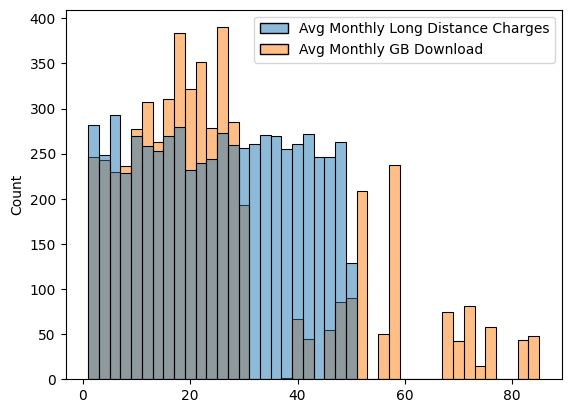

In [ ]:
sns.histplot(churn_df[['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download']])

In [ ]:
churn_df[['Contract', 'Multiple Lines','Internet Type',
          'Online Security','Online Backup','Device Protection Plan','Premium Tech Support',
          'Streaming TV','Streaming Movies','Streaming Music','Unlimited Data']].describe()

,Contract,Multiple Lines,Internet Type,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data
count,7043,6361,5517,5517,5517,5517,5517,5517,5517,5517,5517
unique,3,2,3,2,2,2,2,2,2,2,2
top,Month-to-Month,No,Fiber Optic,No,No,No,No,No,No,No,Yes
freq,3610,3390,3035,3498,3088,3095,3473,2810,2785,3029,4745


In [ ]:
churn_df[churn_df['Internet Type'].isna()][['Online Security','Online Backup','Device Protection Plan','Premium Tech Support','Streaming TV',
                                            'Streaming Movies','Streaming Music','Unlimited Data']].notna().sum()

Online Security           0
Online Backup             0
Device Protection Plan    0
Premium Tech Support      0
Streaming TV              0
Streaming Movies          0
Streaming Music           0
Unlimited Data            0
dtype: int64

In [ ]:
churn_df.groupby('Internet Type')['Avg Monthly GB Download'].mean()

Internet Type
Cable          27.872289
DSL            27.514528
Fiber Optic    25.008896
Name: Avg Monthly GB Download, dtype: float64

In [ ]:
# getting all observation that they got NAs from the column of internet type to contract

filtered_df = churn_df[churn_df.iloc[:, churn_df.columns.get_loc('Avg Monthly GB Download'):churn_df.columns.get_loc('Contract')].isna().all(axis=1)]
filtered_df.shape

(1526, 38)

In [ ]:
# 'Avg Monthly GB Download' = column 16
# 'Contract' = column 26
filtered_df.iloc[:,16:26].head()

,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems that these 1526 missing values in the consecutive 10 columns doesn't happened by coincidence. If the Internet Type is unknown, we are not getting information of the other 9 columns. If internet type is missing (we assume no internet, then we come across null in these columns).

In [ ]:
(churn_df['Internet Service'] == 'No').sum()

1526

Additionally, we found out that if there is no internet service, there is no internet type at all and there are for sure some columns that are redundant as it is not possible without having any internet such as their 'Avg Monthly GB Download'.

Also, for phone service = 'No', fields related to that are null are Multiple Lines and Avg Monthly Long Distance Charges, since clearly it is not possible to have these without a phone service

In [ ]:
(churn_df['Phone Service'] == 'No').sum()

682

In [ ]:
churn_df.loc[churn_df['Phone Service'] == 'No',['Avg Monthly Long Distance Charges','Multiple Lines']].notna().sum()

Avg Monthly Long Distance Charges    0
Multiple Lines                       0
dtype: int64

## Duplicate Value check

In [ ]:
len(churn_df) == len(set(churn_df['Customer ID']))

True

## Identifying customer churn characteristics

In [ ]:
churn_df['Customer Status'].value_counts()

Stayed     4720
Churned    1869
Joined      454
Name: Customer Status, dtype: int64

In [ ]:
# For simplicity, we simply consider Churned and No Churn

churn_df['Customer Status'] = churn_df['Customer Status'].apply(lambda x : 'No Churn' if x!='Churned' else x) 

In [ ]:
churn_df[churn_df['Customer Status'] == 'Churned']['Churn Reason'].value_counts()

Competitor had better devices                313
Competitor made better offer                 311
Attitude of support person                   220
Don't know                                   130
Competitor offered more data                 117
Competitor offered higher download speeds    100
Attitude of service provider                  94
Price too high                                78
Product dissatisfaction                       77
Network reliability                           72
Long distance charges                         64
Service dissatisfaction                       63
Moved                                         46
Extra data charges                            39
Limited range of services                     37
Poor expertise of online support              31
Lack of affordable download/upload speed      30
Lack of self-service on Website               29
Poor expertise of phone support               12
Deceased                                       6
Name: Churn Reason, 

In [ ]:
churn_df[churn_df['Customer Status'] == 'Churned']['Internet Service'].value_counts()

Yes    1756
No      113
Name: Internet Service, dtype: int64

In [ ]:
churn_df[churn_df['Customer Status'] == 'Churned']['Internet Type'].value_counts()

Fiber Optic    1236
DSL             307
Cable           213
Name: Internet Type, dtype: int64

In [ ]:
churn_df[churn_df['Customer Status'] == 'Churned']['Contract'].value_counts()

Month-to-Month    1655
One Year           166
Two Year            48
Name: Contract, dtype: int64

In [ ]:
churn_df[churn_df['Customer Status'] == 'Churned']['Offer'].value_counts()

None       1051
Offer E     426
Offer D     161
Offer B     101
Offer C      95
Offer A      35
Name: Offer, dtype: int64

In [ ]:
churn_df[churn_df['Customer Status'] != 'Churned']['Offer'].value_counts()

None       2826
Offer B     723
Offer A     485
Offer D     441
Offer E     379
Offer C     320
Name: Offer, dtype: int64

### Analysis by Zipcode, comparing churn vs non churn as a % of population

---



In [ ]:
grouped_by_zip = churn_df.groupby(['Zip Code','Customer Status']).count()['Customer ID']
grouped_by_zip = grouped_by_zip.unstack().reset_index()
grouped_by_zip.head()

Customer Status,Zip Code,Churned,No Churn
0,90001,1.0,3.0
1,90002,NaN,4.0
2,90003,1.0,4.0
3,90004,2.0,3.0
4,90005,2.0,2.0


In [ ]:
grouped_by_zip = pd.merge(grouped_by_zip, zip_df, how='left',on='Zip Code')
grouped_by_zip.head()

,Zip Code,Churned,No Churn,Population
0,90001,1.0,3.0,54492
1,90002,NaN,4.0,44586
2,90003,1.0,4.0,58198
3,90004,2.0,3.0,67852
4,90005,2.0,2.0,43019


In [ ]:
grouped_by_zip.fillna(0,inplace=True)
grouped_by_zip['Stay%'] = grouped_by_zip['No Churn']*100  / grouped_by_zip['Population']
grouped_by_zip['Churn%'] = grouped_by_zip['Churned']*100  / grouped_by_zip['Population']
grouped_by_zip.head()


,Zip Code,Churned,No Churn,Population,Stay%,Churn%
0,90001,1.0,3.0,54492,0.005505,0.001835
1,90002,0.0,4.0,44586,0.008971,0.000000
2,90003,1.0,4.0,58198,0.006873,0.001718
3,90004,2.0,3.0,67852,0.004421,0.002948
4,90005,2.0,2.0,43019,0.004649,0.004649


### Locations of people who churned

In [ ]:
map = folium.Map(location=[34.162515,-118.203869], zoom_start=5)
for idx,row in churn_df[churn_df['Customer Status'] == 'Churned'].iterrows():
        folium.Circle(
          location=[row['Latitude'],row['Longitude']],
          color='red',        
          fill=True,
          fill_opacity=1,
          fill_color='red',
       ).add_to(map)
        
        
map

### Locations of people who didn't churn

In [ ]:
map = folium.Map(location=[34.162515,-118.203869], zoom_start=5)
for idx,row in churn_df[churn_df['Customer Status'] != 'Churned'].iterrows():
        folium.Circle(
          location=[row['Latitude'],row['Longitude']],
          color='green',
          fill=True,
          fill_opacity=1,
          fill_color='green',
       ).add_to(map)
        
        
map

Output hidden; open in https://colab.research.google.com to view.

# Data Cleaning Pipeline (identifying steps)

In [ ]:
# check for missing values in the 'colors' column
has_missing = churn_df.select_dtypes(include=['object']).isna().any().any()

if has_missing:
    print('At least one categorical column contains missing values')
else:
    print('No categorical column contains missing values')

At least one categorical column contains missing values


In [ ]:
# Numeric columns
set(churn_df._get_numeric_data().columns)

{'Age',
 'Avg Monthly GB Download',
 'Avg Monthly Long Distance Charges',
 'Latitude',
 'Longitude',
 'Monthly Charge',
 'Number of Dependents',
 'Number of Referrals',
 'Tenure in Months',
 'Total Charges',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Refunds',
 'Total Revenue',
 'Zip Code'}

In [ ]:
# Non-numeric / Categorical columns
set(churn_df.columns) - set(churn_df._get_numeric_data().columns)

{'Churn Category',
 'Churn Reason',
 'City',
 'Contract',
 'Customer ID',
 'Customer Status',
 'Device Protection Plan',
 'Gender',
 'Internet Service',
 'Internet Type',
 'Married',
 'Multiple Lines',
 'Offer',
 'Online Backup',
 'Online Security',
 'Paperless Billing',
 'Payment Method',
 'Phone Service',
 'Premium Tech Support',
 'Streaming Movies',
 'Streaming Music',
 'Streaming TV',
 'Unlimited Data'}

In [ ]:
# Splitting columns

geo_cols = ['Zip Code', 'Latitude', 'Longitude','City']

numeric_cols = ['Age', 'Number of Dependents', 
       'Number of Referrals', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue']

id_col = ['Customer ID']

categorical_cols = ['Contract','Device Protection Plan','Gender','Internet Service',
                    'Internet Type','Married','Multiple Lines','Online Backup',
                    'Online Security','Paperless Billing','Payment Method','Phone Service',
                    'Premium Tech Support','Streaming Movies','Streaming Music','Streaming TV','Unlimited Data']

target_col = ['Customer Status']

other_target_cols = ['Churn Category','Churn Reason','Offer']

In [ ]:
# Checking values of categorical columns for OHE

print("Null Val\tUnique Val\t Name")
for col in categorical_cols:
    print(churn_df[col].isna().sum(),"\t\t",churn_df[col].nunique(),"\t\t",col)

Null Val	Unique Val	 Name
0 		 3 		 Contract
1526 		 2 		 Device Protection Plan
0 		 2 		 Gender
0 		 2 		 Internet Service
1526 		 3 		 Internet Type
0 		 2 		 Married
682 		 2 		 Multiple Lines
1526 		 2 		 Online Backup
1526 		 2 		 Online Security
0 		 2 		 Paperless Billing
0 		 3 		 Payment Method
0 		 2 		 Phone Service
1526 		 2 		 Premium Tech Support
1526 		 2 		 Streaming Movies
1526 		 2 		 Streaming Music
1526 		 2 		 Streaming TV
1526 		 2 		 Unlimited Data


## Imputing null values

Since all the missing values are missing for a reason (No phone => No long distance calls, No Internet => no streaming Movies, no avg GB download, etc.), simple imputing with a constant value will work.

#### Imputing numerical values

In [ ]:
churn_df[numeric_cols].isna().sum()

Age                                     0
Number of Dependents                    0
Number of Referrals                     0
Tenure in Months                        0
Avg Monthly Long Distance Charges     682
Avg Monthly GB Download              1526
Monthly Charge                          0
Total Charges                           0
Total Refunds                           0
Total Extra Data Charges                0
Total Long Distance Charges             0
Total Revenue                           0
dtype: int64

In [ ]:
(churn_df['Avg Monthly Long Distance Charges'] == 0).sum()

0

In [ ]:
(churn_df['Avg Monthly GB Download'] == 0).sum()

0

In [ ]:
num_imp = SimpleImputer(strategy = 'constant', fill_value=0)

churn_df[numeric_cols] = num_imp.fit_transform(churn_df[numeric_cols])
churn_df[numeric_cols].isna().sum()

Age                                  0
Number of Dependents                 0
Number of Referrals                  0
Tenure in Months                     0
Avg Monthly Long Distance Charges    0
Avg Monthly GB Download              0
Monthly Charge                       0
Total Charges                        0
Total Refunds                        0
Total Extra Data Charges             0
Total Long Distance Charges          0
Total Revenue                        0
dtype: int64

#### Imputing Categorical Columns

In [ ]:
churn_df['Churn Category'].fillna('No Churn', inplace=True)
churn_df['Churn Reason'].fillna('No Churn', inplace=True)
churn_df[other_target_cols].isna().sum()

Churn Category    0
Churn Reason      0
Offer             0
dtype: int64

In [ ]:
## TO DO

churn_df['Premium Tech Support'].value_counts(dropna=False)

No     3473
Yes    2044
NaN    1526
Name: Premium Tech Support, dtype: int64

In [ ]:
## TO DO

churn_df['Internet Type'].value_counts(dropna=False)

Fiber Optic    3035
DSL            1652
NaN            1526
Cable           830
Name: Internet Type, dtype: int64

In [ ]:
churn_df['Phone Service'].value_counts(dropna=False)

Yes    6361
No      682
Name: Phone Service, dtype: int64

In [ ]:
churn_df['Multiple Lines'].value_counts(dropna=False)

No     3390
Yes    2971
NaN     682
Name: Multiple Lines, dtype: int64

In [ ]:
churn_df[categorical_cols].isna().sum()

Contract                     0
Device Protection Plan    1526
Gender                       0
Internet Service             0
Internet Type             1526
Married                      0
Multiple Lines             682
Online Backup             1526
Online Security           1526
Paperless Billing            0
Payment Method               0
Phone Service                0
Premium Tech Support      1526
Streaming Movies          1526
Streaming Music           1526
Streaming TV              1526
Unlimited Data            1526
dtype: int64

In [ ]:
churn_df['Internet Type'].fillna('No internet',inplace=True)

In [ ]:
cat_imp = SimpleImputer(strategy = 'constant', fill_value='No')

churn_df[categorical_cols] = cat_imp.fit_transform(churn_df[categorical_cols])
churn_df[categorical_cols].isna().sum()

Contract                  0
Device Protection Plan    0
Gender                    0
Internet Service          0
Internet Type             0
Married                   0
Multiple Lines            0
Online Backup             0
Online Security           0
Paperless Billing         0
Payment Method            0
Phone Service             0
Premium Tech Support      0
Streaming Movies          0
Streaming Music           0
Streaming TV              0
Unlimited Data            0
dtype: int64

In [ ]:
churn_df.isna().sum()

Customer ID                          0
Gender                               0
Age                                  0
Married                              0
Number of Dependents                 0
City                                 0
Zip Code                             0
Latitude                             0
Longitude                            0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data           

## Handling Outliers
Since the data in this dataset are all real customers and outliers could be data points that represent extreme values of customer behavior or other factors that could be relevant to the churn prediction problem. Therefore, it is important that we treat extreme values carefully at this point, we are not removing any outliers to keep the relationship between customer's response and their status as real as possible. However, it depends on the performance of the predictive model of our analysis, there is a space for change of strategy in the future.  

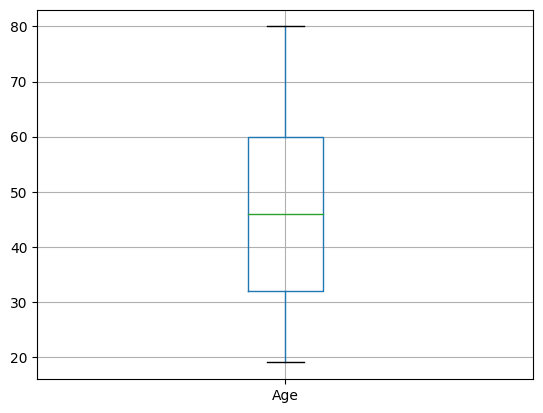

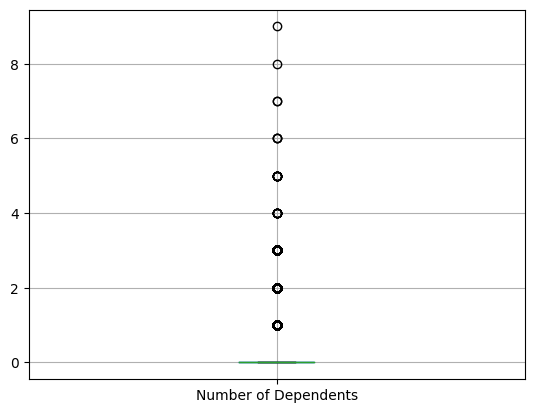

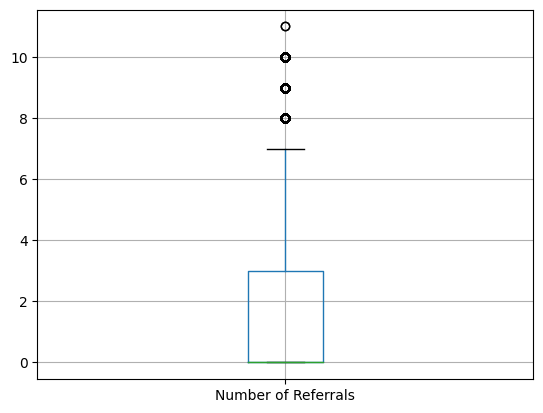

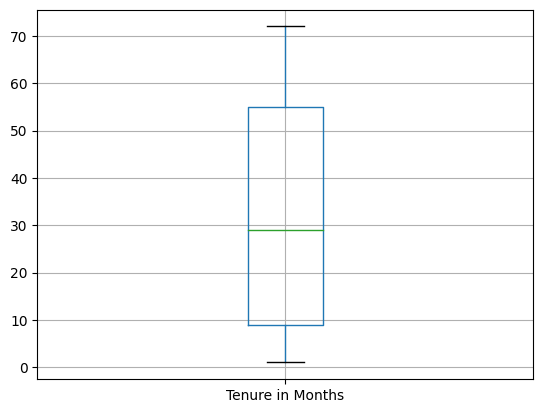

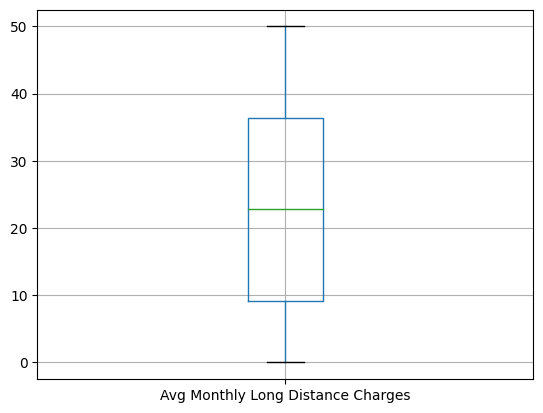

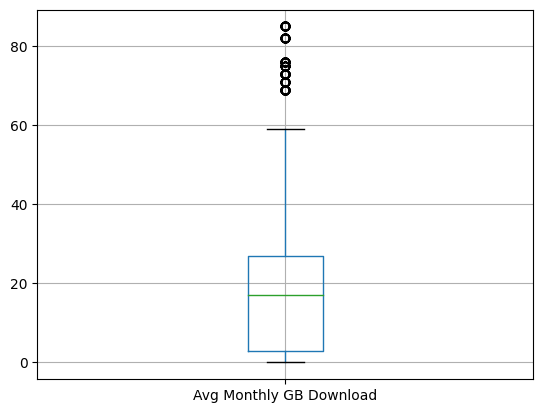

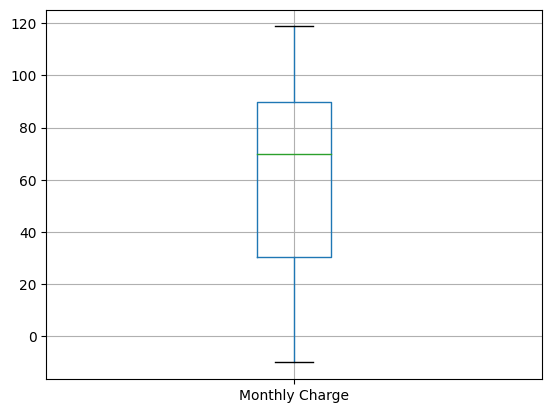

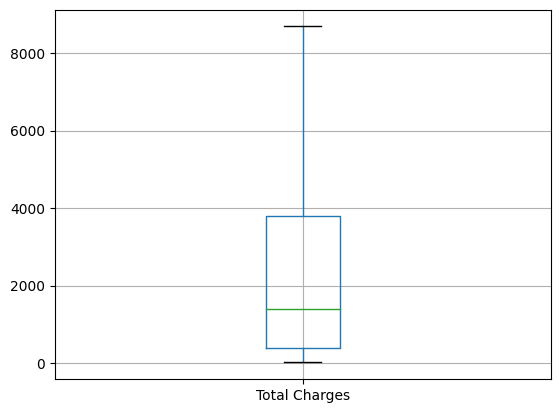

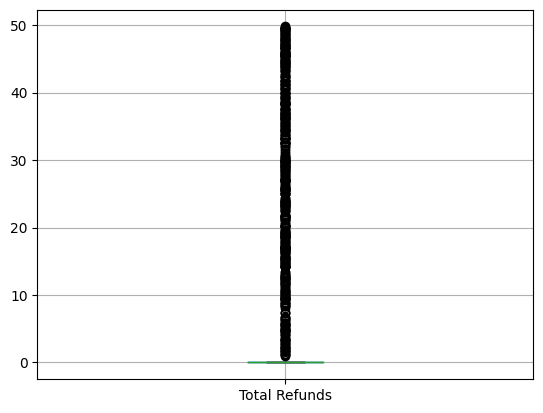

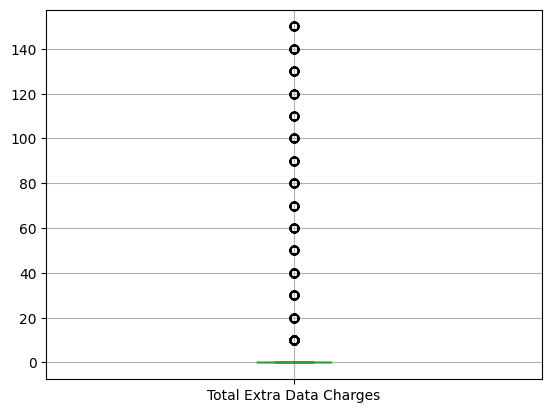

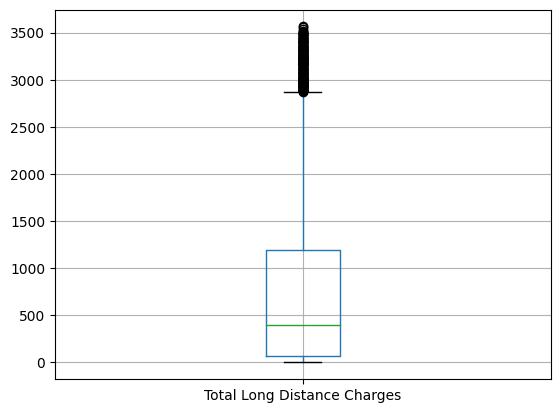

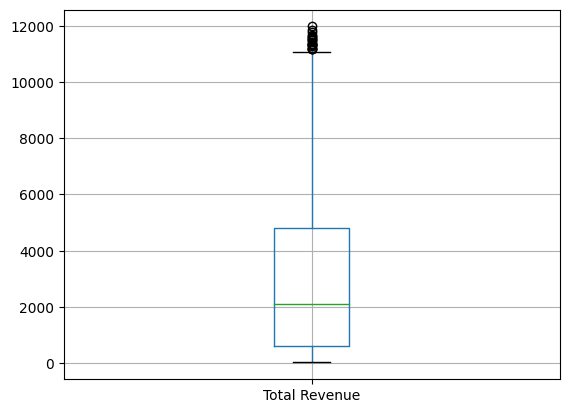

In [ ]:
for col in numeric_cols:
    churn_df[[col]].boxplot()
    plt.show()
    print()

## Scaling / Normalizing numerical features

In [ ]:
scaler = StandardScaler()

scaled = scaler.fit_transform(churn_df[numeric_cols])
scaled

array([[-0.56777322, -0.4868349 ,  0.01603903, ..., -0.27330037,
        -0.43419476, -0.71887199],
       [-0.03043292, -0.4868349 , -0.65040855, ...,  0.12505528,
        -0.77118982, -0.84610754],
       [ 0.20838499, -0.4868349 , -0.65040855, ..., -0.27330037,
        -0.72584373, -0.914111  ],
       ...,
       [-1.46334039, -0.4868349 , -0.65040855, ..., -0.27330037,
        -0.84084492, -1.01374796],
       [-1.52304487, -0.4868349 ,  1.01571039, ..., -0.27330037,
        -0.71705563,  0.60569294],
       [-0.6274777 , -0.4868349 , -0.31718476, ..., -0.27330037,
        -0.88483264,  0.23498104]])

In [ ]:
minmax = MinMaxScaler()

mm_transform = minmax.fit_transform(churn_df[numeric_cols])
mm_transform

array([[0.29508197, 0.        , 0.18181818, ..., 0.        , 0.10702383,
        0.07973337],
       [0.44262295, 0.        , 0.        , ..., 0.06666667, 0.0269895 ,
        0.04924912],
       [0.50819672, 0.        , 0.        , ..., 0.        , 0.03775893,
        0.03295624],
       ...,
       [0.04918033, 0.        , 0.        , ..., 0.        , 0.01044682,
        0.00908431],
       [0.03278689, 0.        , 0.45454545, ..., 0.        , 0.03984605,
        0.39708462],
       [0.27868852, 0.        , 0.09090909, ..., 0.        , 0.        ,
        0.30826611]])

## One Hot Encoding

As we saw above, most categorical variables are Yes/No variables. The most categories we have is 3, therefore OHE will _not_ add a lot of features, after we drop the first variable.

In [ ]:
# ohe = OneHotEncoder(drop='first')

# cat_cols_transformed = ohe.fit_transform(churn_df[categorical_cols])
# cat_cols_transformed

In [ ]:
# Change Yes/No to 1/0

churn_df.replace({'Yes':1,"No":0},inplace=True)

In [ ]:
temp = pd.get_dummies(churn_df[["Contract","Payment Method"]])
temp.head()

,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check
0,0,1,0,0,1,0
1,1,0,0,0,1,0
2,1,0,0,1,0,0
3,1,0,0,1,0,0
4,1,0,0,0,1,0


# Data Pipeline

After identifying the preprocessing steps we should do to our dataset, we will be creating a columntransformer and pipeline to deal with the initial preprocessing and also handle the data leakage issue.



Steps for continuous (numerical) columns(e.g. 'Avg Monthly Long
Distance Charges', 'Avg Monthly GB Download'): 
1. Handling missing value by transforming NAs into 0. Most columns do not have 0 as a value.
2. Scale / Normalize the entire dataset after imputations.


Steps for categorical columns(e.g. 'Internet Type', 'Payment Method'):
There are two types of categorical columns that should be treated differently:

- Columns with 2 classes only (Yes/No)
  1. Handling missing value by transforming NAs into 'No'
  2. No need to perform one-hot encoding since there are only 2 possible classes in each column

- Columns with 3+ classes
  1. Handling missing value by transforming NAs into string that is easy to understand by not going to be affect by the previous transformer, e.g. 'No Internet'
  2. One-hot encoding to create new columns for every classes


Finally, we believe the target variable should be oversampled to address the imbalance in it.

In [ ]:
# columntransformer here

In [ ]:
pipe = Pipeline(steps = 
                [('ohe', OneHotEncoder()),
                 ('scaler', StandardScaler())
                 ])

model_pipe = Pipeline_imb(steps = 
                [('preprocessing', pipe),
                 ('oversampling', RandomOverSampler())
                 #('GNB', GaussianNB())
                 ])

In [ ]:
#model_pipe.fit(X_train, y_train)
#y_pred = model_pipe.predict(X_test)